# Train, Test and Validation Data Split

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

### Dataset Split Configuration

This cell defines the split proportions for dividing the dataset into training, validation, and test sets:

- **Training Set**: 70% of the data
- **Validation Set**: 15% of the data
- **Test Set**: 15% of the data

A floating-point assertion ensures that the split ratios sum exactly to 1.0, maintaining proper partitioning. A fixed random seed (`2025`) is also defined for reproducibility of shuffling operations.


In [2]:
SEED        = 2025
TRAIN_FRAC  = 0.70
VAL_FRAC    = 0.15
TEST_FRAC   = 0.15
assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-6

### Defining Paths to Spectrogram Dataset

This cell defines the directory paths used to load the preprocessed mel spectrogram data:

- `NOTEBOOK_DIR` refers to the current working directory.
- `PROJECT_ROOT` points to the root directory of the project.
- `SPEC_ROOT` identifies the location where spectrogram data is stored.

File paths `X_path` and `y_path` are then constructed to point to the saved NumPy arrays (`X


In [3]:
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SPEC_ROOT    = PROJECT_ROOT / "data" / "spectrograms"
X_path, y_path = SPEC_ROOT / "X_mels.npy", SPEC_ROOT / "y_labels.npy"

### Loading Spectrogram Dataset

The full dataset is loaded from the saved `.npy` files:

- `X` contains mel spectrogram images and is loaded using memory-mapped mode (`mmap_mode="r"`) for efficient access without loading the entire array into RAM.
- `y` contains the corresponding genre labels as a NumPy array.

The variable `N` stores the total number of labeled segments, and the shapes of both arrays are printed to confirm successful loading.


In [ ]:
X = np.load(X_path, mmap_mode="r")           
y = np.load(y_path)                          
N = len(y)
print(f"Loaded full set: X{X.shape}, y{y.shape}")

Loaded full set: X(18972, 150, 150, 1), y(18972,)


### Shuffling and Splitting the Dataset

The dataset is randomly shuffled and partitioned into training, validation, and test sets:

- A random permutation of indices is generated using NumPy’s `default_rng` seeded for reproducibility.
- The total number of samples is split based on the predefined fractions:
  - `TRAIN_FRAC` (70%)
  - `VAL_FRAC` (15%)
  - Remaining 15% is used for the test set.

Three index arrays (`idx_train`, `idx_val`, and `idx_test`) are created to reference the samples in each subset without duplicating the data.


In [5]:
rng      = np.random.default_rng(SEED)
indices  = rng.permutation(N)

n_train  = int(TRAIN_FRAC * N)
n_val    = int(VAL_FRAC   * N)

idx_train = indices[:n_train]
idx_val   = indices[n_train : n_train + n_val]
idx_test  = indices[n_train + n_val:]

### Creating Train, Validation, and Test Sets

The shuffled indices generated earlier are used to extract corresponding data splits from the full dataset:

- `X_train`, `y_train`: Training set inputs and labels.
- `X_val`, `y_val`: Validation set inputs and labels.
- `X_test`, `y_test`: Test set inputs and labels.

Each subset is created by indexing into the original arrays `X` and `y`, ensuring no data leakage between splits.


In [6]:
X_train, y_train = X[idx_train], y[idx_train]
X_val,   y_val   = X[idx_val],   y[idx_val]
X_test,  y_test  = X[idx_test],  y[idx_test]

In [7]:
for name, Xa, ya in [("train", X_train, y_train),
                     ("val",   X_val,   y_val),
                     ("test",  X_test,  y_test)]:
    assert len(Xa) == len(ya), f"{name}: length mismatch"
    assert Xa.ndim == 4,       f"{name}: X ndim != 4"
    assert np.issubdtype(Xa.dtype, np.floating) and np.issubdtype(ya.dtype, np.integer)
    print(f"{name:5s} split OK → {Xa.shape}")

train split OK → (13280, 150, 150, 1)
val   split OK → (2845, 150, 150, 1)
test  split OK → (2847, 150, 150, 1)


### Class Distribution Analysis Across Splits

This cell verifies and visualizes the class balance within the training, validation, and test sets:

- **Genre Mapping**:  
  If the `GENRES` list is not already defined, it is reconstructed by listing genre folders in the dataset directory.

- **`show_counts(...)`**:  
  Prints the number of samples per genre label using Python’s `Counter`, along with the class imbalance ratio (max count / min count). This helps identify any class imbalance that may affect model training.

- **`bar_counts(...)`**:  
  Generates a bar plot showing the number of samples per genre in each split. Class labels are shown using the genre names for better interpretability.

These checks help ensure the dataset splits preserve class diversity and highlight any need for resampling or weighted loss adjustments in future training.


In [8]:
try:
    GENRES
except NameError:
    DATA_ROOT = PROJECT_ROOT / "data" / "genres_original"
    GENRES = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())

In [9]:
def show_counts(y_vec, title):
    from collections import Counter
    cnts = Counter(y_vec)
    ratio = max(cnts.values()) / min(cnts.values())
    print(f"\n{title}\n" + "-"*len(title))
    for lab in sorted(cnts):
        print(f"{lab:2d} – {GENRES[lab]:12s}: {cnts[lab]}")
    print(f"Total: {len(y_vec)}   |  Imbalance ratio: {ratio:.2f}")


In [10]:
def bar_counts(y_vec, title):
    labs, nums = np.unique(y_vec, return_counts=True)
    plt.figure(figsize=(8,3))
    plt.bar(labs, nums, tick_label=[GENRES[i] for i in labs])
    plt.title(title); plt.ylabel("samples")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


Training split
--------------
 0 – blues       : 1295
 1 – classical   : 1340
 2 – country     : 1333
 3 – disco       : 1294
 4 – hiphop      : 1310
 5 – jazz        : 1360
 6 – metal       : 1324
 7 – pop         : 1343
 8 – reggae      : 1355
 9 – rock        : 1326
Total: 13280   |  Imbalance ratio: 1.05


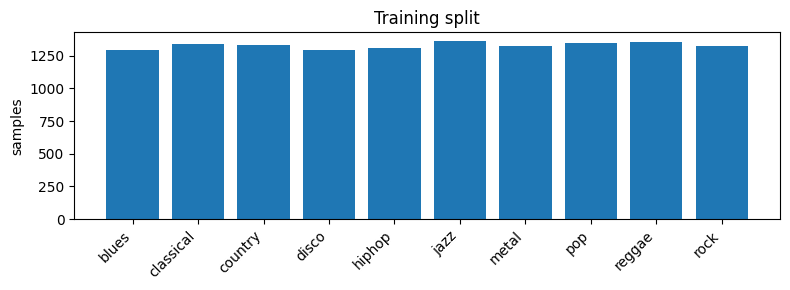


Validation split
----------------
 0 – blues       : 290
 1 – classical   : 287
 2 – country     : 266
 3 – disco       : 317
 4 – hiphop      : 296
 5 – jazz        : 260
 6 – metal       : 293
 7 – pop         : 278
 8 – reggae      : 279
 9 – rock        : 279
Total: 2845   |  Imbalance ratio: 1.22


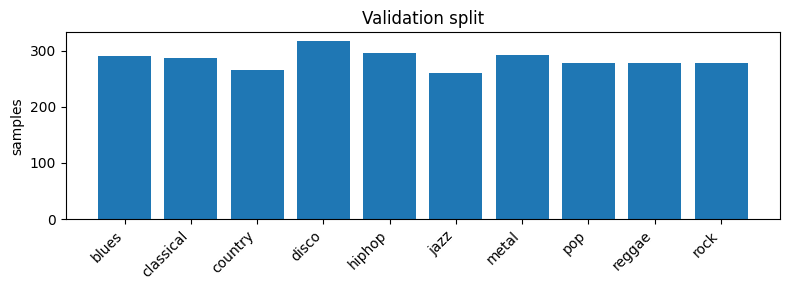


Test split
----------
 0 – blues       : 315
 1 – classical   : 271
 2 – country     : 298
 3 – disco       : 288
 4 – hiphop      : 292
 5 – jazz        : 261
 6 – metal       : 283
 7 – pop         : 279
 8 – reggae      : 266
 9 – rock        : 294
Total: 2847   |  Imbalance ratio: 1.21


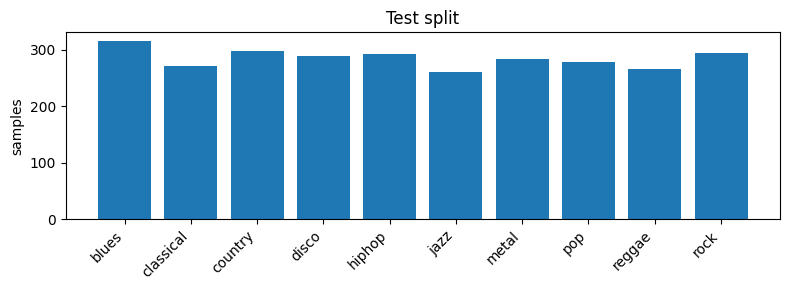

In [11]:

for lbl, y_vec in [("Training split", y_train),
                   ("Validation split", y_val),
                   ("Test split", y_test)]:
    show_counts(y_vec, lbl)
    bar_counts(y_vec, lbl)

***Observations on Class Distribution***

The class distribution across training, validation, and test sets is relatively balanced:

- **Training Set**:  
  Contains 13,280 samples with an imbalance ratio of **1.05**, indicating near-uniform representation across all genres. This provides a solid foundation for unbiased model training.

- **Validation and Test Sets**:  
  Each contains ~2,845 samples, with imbalance ratios of **1.22** and **1.21** respectively. While there is mild variation in class counts (e.g., disco slightly overrepresented in validation), the overall distribution remains acceptable for reliable model evaluation.

No further resampling or weighting is required at this stage, as the class balance is well-maintained across all dataset splits.


### Saving Train, Validation, and Test Splits

This cell saves the final train, validation, and test datasets to a new directory (`data/splits/`) for future model training and evaluation:

- The directory is created if it does not already exist.
- Each of the six arrays (`X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test`) is saved as a separate `.npy` file using NumPy's binary format for efficient storage and loading.
- Pickling is disabled for safety and reproducibility.

Saving the split datasets ensures that data preparation steps do not need to be repeated and enables consistent reuse across different notebooks or experiments.


In [12]:
split_root = PROJECT_ROOT / "data" / "splits"
split_root.mkdir(parents=True, exist_ok=True)

for arr, name in [(X_train, "X_train"), (y_train, "y_train"),
                  (X_val,   "X_val"),   (y_val,   "y_val"),
                  (X_test,  "X_test"),  (y_test,  "y_test")]:
    np.save(split_root / f"{name}.npy", arr, allow_pickle=False)

print(f"\nSaved splits to {split_root}")


Saved splits to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/data/splits
